# Distributional Forecasting in Electiricity Markets: <br>Prediction Interval Averaging vs Quantile Regression Averaging

### References
- Christoffersen, P. F. (1998). Evaluating interval forecasts. International economic review, 841-862.
- Gaba, A., Tsetlin, I., & Winkler, R. L. (2017). Combining interval forecasts. Decision Analysis, 14(1), 1-20.
- Nowotarski, J., & Weron, R. (2018). Recent advances in electricity price forecasting: A review of probabilistic forecasting. Renewable and Sustainable Energy Reviews, 81, 1548-1568.
- Uniejewski, B., Nowotarski, J., & Weron, R. (2016). Automated variable selection and shrinkage for day-ahead electricity price forecasting. Energies, 9(8), 621.
- Weron, R., & Misiorek, A. (2008). Forecasting spot electricity prices: A comparison of parametric and semiparametric time series models. International journal of forecasting, 24(4), 744-763.

#### Notes:
- from **2018-04-02** to 2019-03-31 individual model training
- from **2019-04-01** to 2020-03-29 individual model forecasting & PI training
- from **2020-03-30** to 2021-03-28 individual model forecasting & PI forecasting

In [1]:
import pandas as pd
import numpy as np
import re
from code.holiday import get_holiday
from code.forecast import get_forecast_AR, get_forecast_QRA, get_naive_forecast, PI_combinations
from code.evaluation import get_PI_from_distribution, Christoffersen_scores, pinball_loss, winkler_score, DM_test
from statsmodels.tools.sm_exceptions import ValueWarning
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go
import os
import warnings

# ignore the frequency error in ARIMA function
warnings.filterwarnings('ignore', category=ValueWarning)

### Import data

In [2]:
price_df_raw = pd.read_csv('data/MCP-25032018-28032021.csv')
load_df_raw = pd.read_csv('data/LoadForecast-01042018-28032021.csv')
# after 03/10/2018 -> permanent +03 gmt

preprocess = lambda df: df.set_index( 
    # merge date and time to get datetime and set index
    pd.to_datetime(
        df['Date'] + " " + df['Hour'],
        dayfirst=True
    )
) \
.drop(columns=['Date', 'Hour']) \
.apply(
    # remove decimal seperator ","
    lambda col: col.astype(str).str.replace(',','').astype(float)
) \
.tz_localize('Europe/Istanbul') # add timezone info

price_df = preprocess(price_df_raw)
price_df.rename(columns={x: re.findall('\((.*)/', x)[0] for x in price_df.columns}, inplace=True)

load_df = preprocess(load_df_raw).rename(columns={'Load Forecast (MWh)':'Load_Forecast_MWh'})

### Convert data to hourly shape

In [3]:
# Hourly Dataframes
## concatenate each hour's dataset vertically
get_hourly_df = lambda df, column: df.groupby(df.index.hour)[column].apply(
    lambda col: col.to_dict()).to_frame().dropna()

hourly_load_df = get_hourly_df(load_df, 'Load_Forecast_MWh')
hourly_price_df = pd.concat(
    [ get_hourly_df(price_df, col) for col in price_df ],
    axis=1
)
hourly_holiday_df = get_hourly_df(get_holiday(price_df), 'Holiday')
hourly_min_price_l1 = pd.concat(
    [get_hourly_df(price_df.resample('D').transform('min').shift(24), col) for col in price_df],
    axis=1
)
hourly_min_price_l1.rename(columns={x: f"{x}_min_l1" for x in hourly_min_price_l1.columns}, inplace=True)

hourly_weekday_df = hourly_price_df.assign(
    Saturday = lambda df: (df.index.get_level_values(1).day_of_week == 5) * 1,
    Sunday = lambda df: (df.index.get_level_values(1).day_of_week == 6) * 1,
    Monday = lambda df: (df.index.get_level_values(1).day_of_week == 0) * 1,
).filter(regex='day')

### Choose currency and merge the series

In [4]:
currency = 'EUR' # 'MCP (TL/MWh), PTF (USD/MWh), PTF (EUR/MWh)
main_df = pd.concat([
    hourly_price_df[currency].to_frame(name='Price_MWh').groupby(level=0, axis=0).apply(lambda hour: hour.diff(1)),
    hourly_load_df.groupby(level=0, axis=0).apply(lambda hour: hour.diff(1)),
    hourly_min_price_l1.filter(regex=currency).rename(columns={f"{currency}_min_l1": "Price_MWh_min_l1"})
    .groupby(level=0, axis=0).apply(lambda hour: hour.diff(1)),
    hourly_holiday_df,
    hourly_weekday_df
    ], axis=1
)

price_df_final = price_df[currency].to_frame(name='Price_MWh')

# Individual Models
Three different models are employed; ARX (Autoregresive Model with exogenous variables), mARX (multi-day ARX) and TARX (Threshold Autoregressive model with exogenous variables). ARX and mARX models follows the the structure in Nowotarski & Weron(2018), and TARX model follows the structure explained in Weron & Misiorek (2008). Models with lags 1 to 7 are also tried to be regularized using _Lasso_ (least absolute shrinkage and selection operator), its implementation is inspired by Uniejewski et al. (2016).

Each Model is constructed seperately for each hour due to correlative behavior of prices in a day. Except models with lasso, all models are estimated using statsmodels' ARIMA function with yule walker equations as estimator.


### Notation:
$p_{d,h}$: the at $h^{th}$ hour in day $d$.<br>
$p_{d-1,h}^{min}$: minimum price in the previous day.<br>
$load_{d,h}$: Load forecast for $h^{th}$ hour in day $d$.<br>
$D_{day, h}$: Dummy for $day \in\{Saturday, Sunday, Monday, Holiday\}$ where holiday is national holidays in Turkey.<br>
**Note**: Due to stationarity concerns; price, price lags, minimum prices and load forecasts are differenced by 1.

## Models

### ARX
**With lags 1,2,7**<br>
$p_{d,h} = \beta_{h,0} + \beta_{h,1}p_{d-1,h} + \beta_{h,2}p_{d-2,h} + \beta_{h,3}p_{d-7,h} + \beta_{h,4}p_{d-1,h} + \beta_{h,5}p_{d-1}^min + \beta_{h,5}load_{d,h} + \beta_{h,6}D_{Sat,h} + \beta_{h,7}D_{Sun,h} + \beta_{h,8}D_{Mon,h} + \beta_{h,9}D_{Holiday,h}$ <br>

**With lags 1,2,...,7**<br>
$p_{d,h} = \beta_{h,0} + \sum_{i=0}^{7} \beta_{h,i}p_{d-i,h} + \beta_{h,8}p_{d-1}^min + \beta_{h,9}load_{d,h} + \beta_{h,10}D_{Sat,h} + \beta_{h,11}D_{Sun,h} + \beta_{h,12}D_{Mon,h} + \beta_{h,13}D_{Holiday,h}$ <br>

### TARX
If mean of yesterday prices is higher than mean of 8 days ago than state 1 else state 0.<br>

**With lags 1,2,7**<br>
$p_{d,h} = \beta_{h,0} +\beta_{h,1,j}p_{d-1,h} + \beta_{h,2,j}p_{d-2,h} + \beta_{h,3,j}p_{d-7,h} + \beta_{h,4,j}p_{d-1,h} + \beta_{h,5,j}p_{d-1}^min + \beta_{h,5,j}load_{d,h} + \beta_{h,6,j}D_{Sat,h} + \beta_{h,7,j}D_{Sun,h} + \beta_{h,8,j}D_{Mon,h} + \beta_{h,9,j}D_{Holiday,h}$ <br>
for _j_ in {0,1} as state 0 and state 1.<br>

**With lags 1,2,...,7**<br>
$p_{d,h} = \beta_{h,0} +\sum_{i=0}^{7} \beta_{h,i,j}p_{d-l,h} + \beta_{h,8,j}p_{d-1}^min + \beta_{h,9,j}load_{d,h} + \beta_{h,10,j}D_{Sat,h} + \beta_{h,11,j}D_{Sun,h} + \beta_{h,12,j}D_{Mon,h} + \beta_{h,13,j}D_{Holiday,h}$ <br>
for _j_ in {0,1} as state 0 and state 1.<br>

### mARX
**With lags 1,2,7**<br>
$p_{d,h} = \beta_{h,0} +\beta_{h,1}p_{d-1,h} + \beta_{h,2}p_{d-2,h} + \beta_{h,3}p_{d-7,h} + \beta_{h,4}p_{d-1,h} + \beta_{h,5}p_{d-1}^min + \beta_{h,5}load_{d,h} + \beta_{h,6}D_{Sat,h} + \beta_{h,7}D_{Sun,h} + \beta_{h,8}D_{Mon,h} + \beta_{h,9}D_{Holiday,h} + \beta_{h,6}D_{Sat,h}p_{d-1,h} + \beta_{h,7}D_{Sun,h}p_{d-1,h} + \beta_{h,8}D_{Mon,h}p_{d-1,h}$ <br>

**With lags 1,2,...,7**<br>
$p_{d,h} = \beta_{h,0} + \sum_{i=0}^{7} \beta_{h,l}p_{d-i,h} + \beta_{h,8}load_{d,h} + \beta_{h,9}D_{Sat,h} + \beta_{h,10}D_{Sun,h} + \beta_{h,11}D_{Mon,h} + \beta_{h,12}D_{Holiday,h} + \beta_{h,13}D_{Sat,h}p_{d-1,h} + \beta_{h,14}D_{Sun,h}p_{d-1,h} + \beta_{h,15}D_{Mon,h}p_{d-1,h}$ <br>

## Lasso
For each model with lags 1,2,...,7, a regulariazition method called Lasso is employed and insignificant coefficients are forced to be zero in the model. Coefficients of lasso are calculated as such; <br>
$\beta^{Lasso} = \underset{\beta_{h,i}}{\operatorname{argmin}} \left\{ \sum_{d,h} \left( p_{d,h} - \sum_{i}^{n} \beta_{h, i}X_{h,i} \right)^{2} + \lambda \sum_{i}^{n} |\beta_{h,i}| \right\}$ <br>
where $\lambda$ is chosen using point forecasts between period 2019-04-01 and 2020-03-29.

## Forecasts
Point forecasts for each hour are acquired using the last year's values (52\*7 days) as training and one-step ahead forecast is calculated by also taking into account of exogenous variables (load, min price and such.)


Distributional forecasts are calculated in three ways;
- Historical; residuals of the model, i.e. the prediction error in the last year.
- Distributional; random values from a zero-mean normal distibution with std of residuals.
- Bootstrap; a new price series is estimated using the coefficients of the model and a value is forecasted; for 250 times. This process provides a distribution of forecasts (with population of 250).

**Note**: Since the first differenced series are used in the models, the point and distributional forecasts are the differences from the last value. In the forecasting function, the previous value added to point forecast to get the adjusted forecast which is added to distributional forecast to skew the distribution and pile the distribution around the adjusted point forecast.

#### Best parameter for regulazitor

In [5]:
dates=('2019-04-01', '2020-03-29')
alpha_dict = {}
for model in ['AR', 'mAR', 'TAR']:
    file_name = f"lasso_results_{model}.csv"
    if file_name in os.listdir('./data'):
        result_df = pd.read_csv(
            f'./data/{file_name}',
            index_col=0,
            header=[0,1],
            parse_dates=True,
            date_parser=lambda x: pd.Timestamp(x, tz='Europe/Istanbul')
        )
    else:
        result_dict = {}
        for alpha in np.linspace(0.8, 1, 21):
            result_dict.update( {
                alpha: get_forecast_AR(
                    main_df,
                    price_df_final,
                    range(1,8),
                    forecast_dates=dates,
                    model_type='AR',
                    method='LASSO',
                    lasso_args={
                        'alpha':alpha,
                        'max_iter':10000,
                        'fit_intercept':True,
                        'selection':'random'
                    }
                )}
            )
        result_df = pd.concat(result_dict.values(), axis=1, keys=result_dict.keys())
        result_df.to_csv(f'./data/{file_name}')
    argmin = result_df.xs('Forecast_added', level=1, axis=1) \
        .apply(
            lambda col: np.nanmean( price_df_final.sub(col, axis=0) **2 )
        ).idxmin()
    print(f"For {model} model best alpha is {argmin}")
    alpha_dict.update({model: float(argmin)})

For AR model best alpha is 0.9
For mAR model best alpha is 0.8
For TAR model best alpha is 0.8


In [6]:
model_names = [
    'ARX_1_2_7','ARX_to_7', 'ARX_to_7_w_lasso',
    'TARX_1_2_7','TARX_to_7', 'TARX_to_7_w_lasso',
    'mARX_1_2_7','mARX_to_7', 'mARX_to_7_w_lasso',
]

### Point Forecasts

In [7]:
p_path = './data/Point_forecasts'
for model in model_names:
    # if already generated, import from csv
    file_name = f"{model}_Point_forecast.csv"
    if f"{model}_Point_forecast.csv" in os.listdir(p_path):
        globals()[model] = pd.read_csv(
            f'{p_path}/{file_name}',
            index_col=0,
            parse_dates=True,
            date_parser=lambda x: pd.Timestamp(x, tz='Europe/Istanbul')
        )
    else:
        lags = [1,2,7] if '1_2_7' in model else range(1,8)
        model_type = re.match('.*(AR)', model)[0]
        method = 'lasso' if 'lasso' in model else 'arima'
        # construct the model
        globals()[model] = get_forecast_AR(
            main_df,
            price_df_final,
            lags,
            forecast_dates=dates,
            model_type=model_type,
            method=method,
            lasso_args={
                'alpha': alpha_dict[model_type],
                'fit_intercept': True,
                'selection': 'random'
            }
        )
        globals()[model].to_csv(f'{p_path}/{model}_Point_forecast.csv')

### Distrubitonal Forecasts

In [8]:
#### Only for 1 week #####
sample_week = ('2020-03-30', '2020-04-05')
for model in model_names:
    # if already generated, import from csv
    d_path = './data/Distributional_forecasts'
    file_name = f"{model}_sample.csv"
    if file_name in os.listdir(d_path):
        globals()[model + '_to_add'] = pd.read_csv(
            f'{d_path}/{file_name}',
            index_col=0,
            parse_dates=True,
            date_parser=lambda x: pd.Timestamp(x, tz='Europe/Istanbul')
        )
        globals()[model] = pd.concat([globals()[model], globals()[model + '_to_add']])
    else: # generate data ### TAKES AROUND 4 hours
        # adjust parameters
        lags = [1,2,7] if '1_2_7' in file_name else range(1,8)
        model_type = re.match('.*(AR)', model)[0]
        method = 'lasso' if 'lasso' in model else 'arima'
        # construct the model
        globals()[model + '_to_add'] = get_forecast_AR(
            main_df,
            price_df_final,
            lags,
            forecast_dates=sample_week,
            model_type=model_type,
            method=method,
            lasso_args={
                'alpha': alpha_dict[model_type],
                'fit_intercept': True,
                'selection': 'random'
            },
            PI_calculate=True,
            bootstrap_B=250,
        )
        globals()[model + '_to_add'].to_csv(f'{d_path}/{file_name}')

## Quantile Regression Averaging
Construct distribution of forecasts using point forecasts of individual models and quantile regression model (Nowotarski & Weron, 2018).

In [9]:
# Construct QRA only for sample week
qra_range = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
qra_df = pd.concat([
    ARX_1_2_7.Forecast_added.to_frame(name='ARX_1_2_7'),
#     ARX_to_7.Forecast_added.to_frame(name='ARX_to_7'),
    ARX_to_7_w_lasso.Forecast_added.to_frame(name='ARX_to_7_w_lasso'),
    TARX_1_2_7.Forecast_added.to_frame(name='TARX_1_2_7'),
#     TARX_to_7.Forecast_added.to_frame(name='TARX_to_7'),
    TARX_to_7_w_lasso.Forecast_added.to_frame(name='TARX_to_7_w_lasso'),
    mARX_1_2_7.Forecast_added.to_frame(name='mARX_1_2_7'),
#     mARX_to_7.Forecast_added.to_frame(name='mARX_to_7'),
    mARX_to_7_w_lasso.Forecast_added.to_frame(name='mARX_to_7_w_lasso'),
    price_df_final.loc[ARX_1_2_7.index]
], axis=1)

qra_forecast_df = get_forecast_QRA(qra_df, qra_range, sample_week)

## Naive Forecast
Each hour in Tuesday, Wednesday, Thursday and Friday equals to previous day's value, each hour in Monday, Saturday and Sunday is the same as last week's value (Nowotarski & Weron, 2018). Distributional forecasts are calculated using the error of point forecast in the last year (subsequent 52*7 days).

In [10]:
# NAIVE forecast for total data
naive_forecast_df = get_naive_forecast(price_df_final, forecast_dates=('2019-04-01', '2021-03-28'))

## Sample Plot

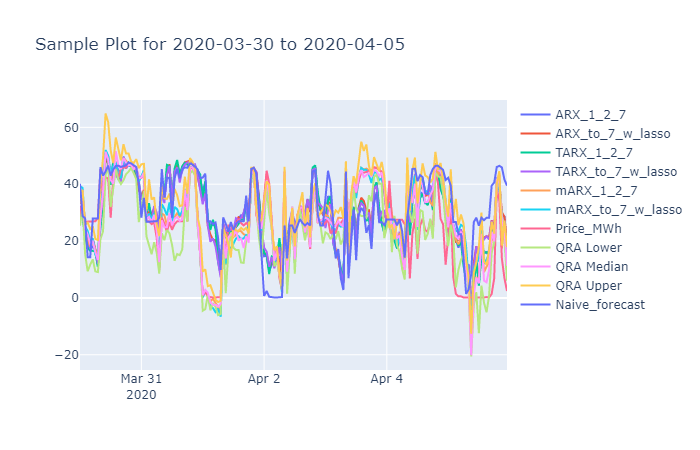

In [11]:
fig_df = pd.concat([
    qra_df.loc[sample_week[0]:],
    qra_forecast_df['0.05'].to_frame('QRA Lower'),
    qra_forecast_df['0.5'].to_frame('QRA Median'),
    qra_forecast_df['0.95'].to_frame('QRA Upper'),
    naive_forecast_df.loc[sample_week[0]:sample_week[1]].Naive_forecast
],axis=1
)

fig = go.Figure()
for col in fig_df:
    fig.add_trace(go.Scatter(y=fig_df[col], x=fig_df.index, name=col))
fig.update_layout(
    hovermode="x",
    title=f'Sample Plot for {sample_week[0]} to {sample_week[1]}'
)
fig.show('png')
# fig.show() to get the interactive plot

## Reliability

#### Get percentiles of naive distributional forecast
Since the negative prices are not allowed in Turkish market, negative values are set to 0.

In [12]:
percentile_df_naive = get_PI_from_distribution(
    naive_forecast_df.PI_historical,
    return_negative_values=False,
    percentiles=np.array([5, 25, 50, 75, 95])
)

### Unconditional and Conditional Coverage
#### Showcase using naive forecast
Unconditional coverage likelihood ratio (i.e. Kupiec's proportion of failures) test and Conditional Coverage likelihood ratio test (Nowotarski & Weron, 2018; Christoffersen, 1998)

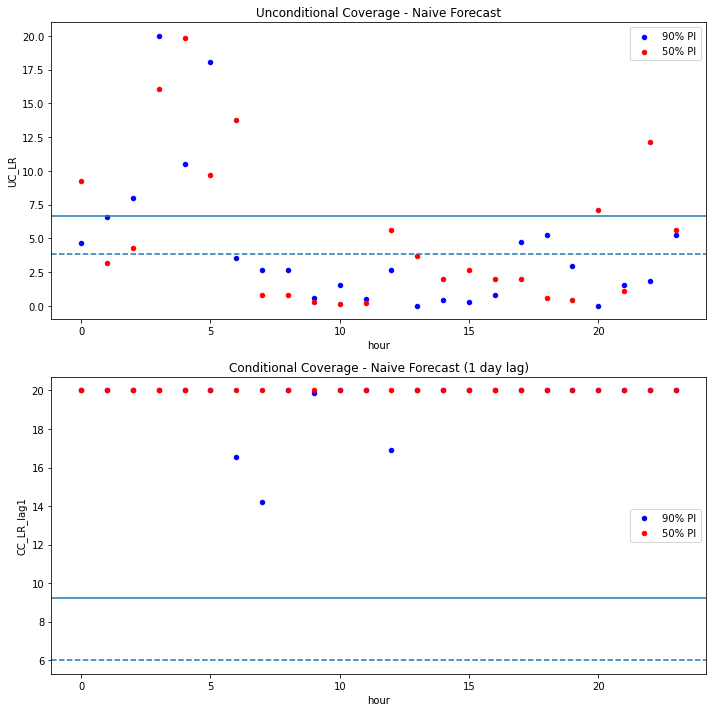

In [13]:
lags = [1]# [1,2,7]
Coverage_LR_Scores_naive_50 = Christoffersen_scores(
    percentile_df=percentile_df_naive,
    realized=price_df_final,
    PI=0.5,
    lags=lags
)
Coverage_LR_Scores_naive_90 = Christoffersen_scores(
    percentile_df=percentile_df_naive,
    realized=price_df_final,
    PI=0.9,
    lags=lags
)

fig, ax= plt.subplots(len(lags)+1, figsize=(10,10))
ax[0].set_title('Unconditional Coverage - Naive Forecast')
Coverage_LR_Scores_naive_90.UC_LR.apply(lambda x: 20 if x>20 else x).reset_index().plot(
    x='index', y='UC_LR', kind='scatter', ax=ax[0], color='blue', label='90% PI'
)
Coverage_LR_Scores_naive_50.UC_LR.apply(lambda x: 20 if x>20 else x).reset_index().plot(
    x='index', y='UC_LR', kind='scatter', ax=ax[0], color='red', label='50% PI', xlabel='hour'
)
ax[0].axhline(y=stats.chi2.ppf(0.99,df=1))
ax[0].axhline(y=stats.chi2.ppf(0.95,df=1), ls='--')

for i, l in zip(range(1,len(lags)+1), lags):
    ax[i].set_title(f'Conditional Coverage - Naive Forecast ({l} day lag)')
    Coverage_LR_Scores_naive_90[f'CC_LR_lag{l}'].apply(lambda x: 20 if x>20 else x).reset_index().plot(
        x='index', y=f'CC_LR_lag{l}', kind='scatter', ax=ax[i], color='blue', label='90% PI'
    )
    Coverage_LR_Scores_naive_50[f'CC_LR_lag{l}'].apply(lambda x: 20 if x>20 else x).reset_index().plot(
        x='index', y=f'CC_LR_lag{l}', kind='scatter', ax=ax[i], color='red', label='50% PI',  xlabel='hour'
    )
    ax[i].axhline(y=stats.chi2.ppf(0.99,df=2))
    ax[i].axhline(y=stats.chi2.ppf(0.95,df=2), ls='--')

fig.tight_layout()
plt.show()

## Get Prediction Intervals and combinations
This section grabs the distributional forecast of each model, combines them by utilizing various methods to get a lower and a upper bound following Gaba et al. (2017);
- Mean; simple average of lower and upper bounds of each model included.
- Median; median value of lower and upper bounds of each model included.
- Envelope; minimum of lower bounds and maximum of upper bounds.
- Interior trimming; excludes upper $\beta$ percent of the lower bounds and lower $\beta$ percent of upper bounds and takes a simple average. (Wider than simple average given $1>\beta>0$)
- Exterior trimming; excludes lower $\beta$ percent of the lower bounds and upper $\beta$ percent of upper bounds and takes a simple average. (Narrower than simple average given $1>\beta>0$)
- Probability averaging of endpoints and simple averaging of midpoints (PM): assumes the mean of each prediction intervals' bounds as the midpoint of a standard normal distribution which computes lower and upper bounds from.

In [18]:
def get_PI_wrapper_csv(df, percentiles=np.array([5, 25, 50, 75, 95])):
    """Temporary function due to csv saving issues of distributions.
    """
    if (df.filter(regex='^PI.*(l|p)$').dtypes == 'object').all():
        df_ = df.filter(regex='^PI.*(l|p)$') \
            .apply(
                lambda col: col.apply(
                    lambda x: np.array(re.sub('(\n|\[|\])', '',x).split(), dtype=float)
                )
            )
    PI_dict = {col: get_PI_from_distribution(
            df_[col],
            return_negative_values=False,
            percentiles=percentiles
        ) 
     for col in df_.columns
    }
    return pd.concat(PI_dict.values(), axis=1, keys=PI_dict.keys())

for model in model_names:
    locals()[model+'_clean'] = get_PI_wrapper_csv(eval(model).dropna())

PI_combinations_df = PI_combinations(
    models=[
        ARX_1_2_7_clean.PI_historical,
        ARX_1_2_7_clean.PI_distributional,
        ARX_1_2_7_clean.PI_bootstrap,
        ARX_to_7_clean.PI_historical,
        ARX_to_7_clean.PI_distributional,
        ARX_to_7_clean.PI_bootstrap,
        ARX_to_7_w_lasso_clean.PI_historical,
        ARX_to_7_w_lasso_clean.PI_distributional,
        ARX_to_7_w_lasso_clean.PI_bootstrap,
        mARX_1_2_7_clean.PI_historical,
        mARX_1_2_7_clean.PI_distributional,
        mARX_1_2_7_clean.PI_bootstrap,
        mARX_to_7_clean.PI_historical,
        mARX_to_7_clean.PI_distributional,
        mARX_to_7_clean.PI_bootstrap,
        mARX_to_7_w_lasso_clean.PI_historical,
        mARX_to_7_w_lasso_clean.PI_distributional,
        mARX_to_7_w_lasso_clean.PI_bootstrap,
        TARX_1_2_7_clean.PI_historical,
        TARX_1_2_7_clean.PI_distributional,
        TARX_1_2_7_clean.PI_bootstrap,
        TARX_to_7_clean.PI_historical,
        TARX_to_7_clean.PI_distributional,
        TARX_to_7_clean.PI_bootstrap,
        TARX_to_7_w_lasso_clean.PI_historical,
        TARX_to_7_w_lasso_clean.PI_distributional,
        TARX_to_7_w_lasso_clean.PI_bootstrap,
    ],
    PI = [0.5, 0.9],
    beta = 0.4 # for trimming
)

# Sharpness

## Winkler Score

In [19]:
### Naive
winkler_naive_90 = winkler_score(percentile_df_naive, price_df_final, PI=0.9)
winkler_naive_50 = winkler_score(percentile_df_naive, price_df_final, PI=0.5)
### ARX 1,2,7
winkler_ARX127_90 = winkler_score(get_PI_wrapper_csv(ARX_1_2_7.dropna()).PI_bootstrap, price_df_final, PI=0.9)
winkler_ARX127_50 = winkler_score(get_PI_wrapper_csv(ARX_1_2_7.dropna()).PI_bootstrap, price_df_final, PI=0.5)
# QRA
winkler_qra_90 = winkler_score(qra_forecast_df, price_df_final, PI=0.9)
winkler_qra_50 = winkler_score(qra_forecast_df, price_df_final, PI=0.5)
### PI combinations
winkler_PIcombinations_90_df = PI_combinations_df.groupby(level=0, axis=1).apply(
    lambda method: winkler_score(method.droplevel(0,1), price_df_final, PI=0.9)
)
winkler_PIcombinations_50_df = PI_combinations_df.groupby(level=0, axis=1).apply(
    lambda method: winkler_score(method.droplevel(0,axis=1), price_df_final, PI=0.5)
)

## Diebold - Mariano test
Test whether the difference in winkler scores is significant for two competing models.

In [20]:
# 90% PI
DM_winkler_ARX127_vs_naive_90 = DM_test(winkler_ARX127_90.Winkler_score, winkler_naive_90.Winkler_score, alpha=0.1, two_sided=True)
DM_winkler_PIcomb_vs_ARX127_90 = winkler_PIcombinations_90_df.groupby(level=0, axis=1).apply(
    lambda method: DM_test(method.droplevel(0,1).Winkler_score, winkler_ARX127_90.Winkler_score, alpha=0.1, two_sided=True)
)
DM_winkler_PIcomb_vs_naive_90 = winkler_PIcombinations_90_df.groupby(level=0, axis=1).apply(
    lambda method: DM_test(method.droplevel(0,1).Winkler_score, winkler_naive_90.Winkler_score, alpha=0.1, two_sided=True)
)
DM_winkler_PIcomb_vs_qra_90 = winkler_PIcombinations_90_df.groupby(level=0, axis=1).apply(
    lambda method: DM_test(method.droplevel(0,1).Winkler_score, winkler_qra_90.Winkler_score, alpha=0.1, two_sided=True)
)
# 50% PI
DM_winkler_ARX127_vs_naive_50 = DM_test(winkler_ARX127_50.Winkler_score, winkler_naive_50.Winkler_score, alpha=0.1, two_sided=True)
DM_winkler_PIcomb_vs_ARX127_50 = winkler_PIcombinations_50_df.groupby(level=0, axis=1).apply(
    lambda method: DM_test(method.droplevel(0,1).Winkler_score, winkler_ARX127_50.Winkler_score, alpha=0.1, two_sided=True)
)
DM_winkler_PIcomb_vs_naive_50 = winkler_PIcombinations_50_df.groupby(level=0, axis=1).apply(
    lambda method: DM_test(method.droplevel(0,1).Winkler_score, winkler_naive_50.Winkler_score, alpha=0.1, two_sided=True)
)
DM_winkler_PIcomb_vs_qra_50 = winkler_PIcombinations_50_df.groupby(level=0, axis=1).apply(
    lambda method: DM_test(method.droplevel(0,1).Winkler_score, winkler_qra_50.Winkler_score, alpha=0.1, two_sided=True)
)

In [21]:
DM_winkler_PIcomb_vs_naive_50

,Envelope,ExtTrim,IntTrim,Mean,Median,PM
,DM-decision,DM-decision,DM-decision,DM-decision,DM-decision,DM-decision
0,-1,0,-1,0,1,0
1,-1,1,-1,0,1,-1
2,-1,0,-1,-1,1,-1
3,-1,0,-1,-1,1,-1
4,-1,0,-1,-1,1,-1
5,-1,0,-1,-1,0,-1
6,-1,0,-1,-1,0,-1
7,-1,0,-1,-1,0,-1
8,-1,0,-1,0,0,-1
